In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from utils import loadMATDataHack, spikeTimes

In [2]:
data = loadMATDataHack("session1.mat")
print(data.keys())

dict_keys(['spikes_pfc', 'spikes_hpc', 'spikes_nr', 'ripples', 'spindles', 'nrem', 'rem', 'wake', 'protocol_times', 'protocol_names', 'nr_isr', 'nr_isa'])


In [3]:
print(data['spikes_hpc'][:5])

print(np.min(data['spikes_hpc'][:,1]), np.max(data['spikes_hpc'][:,1]))
print(np.min(data['spikes_nr'][:,1]), np.max(data['spikes_nr'][:,1]))
print(np.min(data['spikes_pfc'][:,1]), np.max(data['spikes_pfc'][:,1]))

print(data['wake'][:5])
print(data['rem'][:5])
print(data['nrem'][:5])

print(data['protocol_names'])
print(data['protocol_times'])


[[0.0164  1.     ]
 [0.04585 1.     ]
 [0.05075 2.     ]
 [0.06245 3.     ]
 [0.0654  1.     ]]
1.0 29.0
30.0 81.0
82.0 140.0
[[   0.   1454.  ]
 [2709.86 2724.52]
 [2926.   3208.  ]
 [3347.03 3376.  ]
 [3612.   4554.  ]]
[[1556. 1578.]
 [1614. 1628.]
 [1808. 1832.]
 [2058. 2078.]
 [2270. 2290.]]
[[1454. 1556.]
 [1578. 1614.]
 [1628. 1808.]
 [1832. 2058.]
 [2078. 2270.]]
['sleep1', 'task1', 'sleep2', 'task2', 'sleep3']
[[    0.      7263.3984]
 [ 7263.3984 10000.4736]
 [10000.4736 17244.4928]
 [17244.4928 20000.32  ]
 [20000.32   27149.4016]]


In [ ]:
spikes_hpc = spikeTimes(data['spikes_hpc'], data['protocol_times'])
spikes_nr = spikeTimes(data['spikes_nr'], data['protocol_times'])
spikes_pfc = spikeTimes(data['spikes_pfc'], data['protocol_times'])

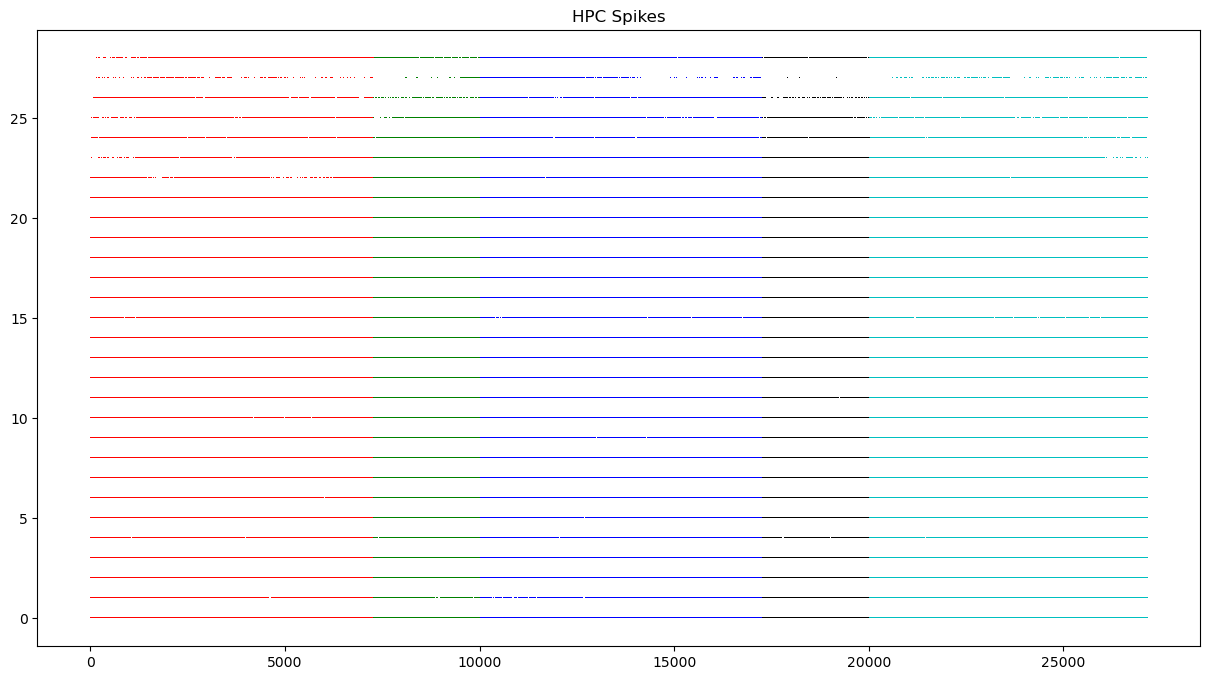

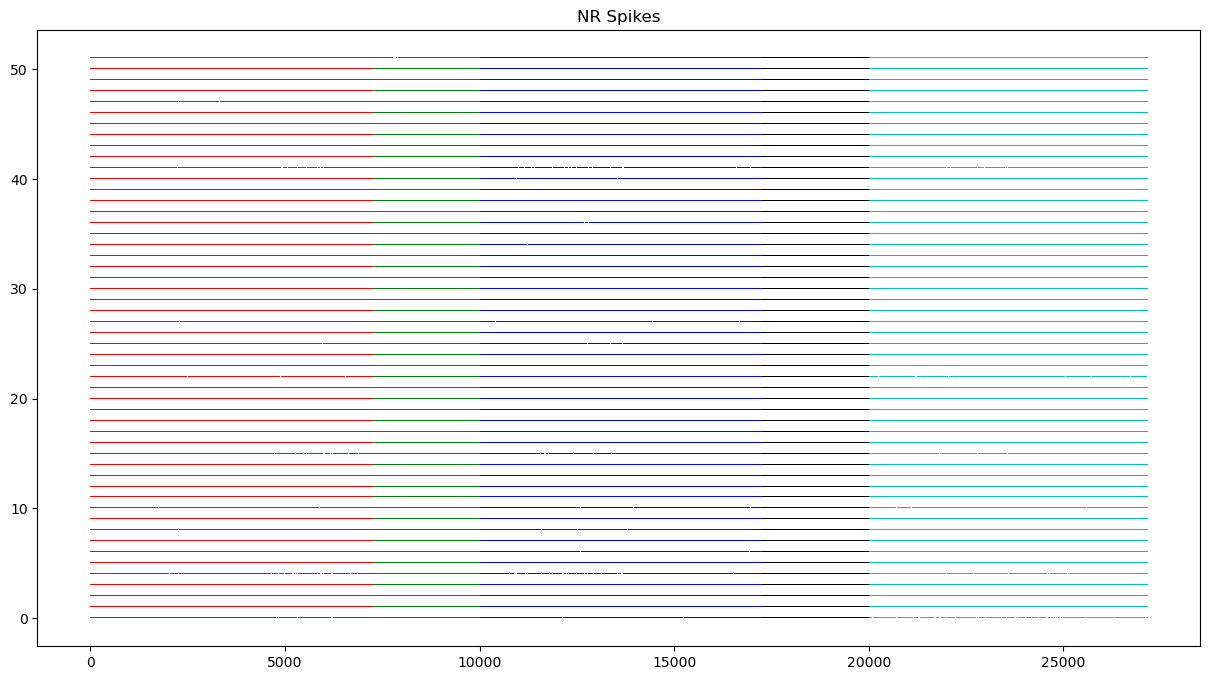

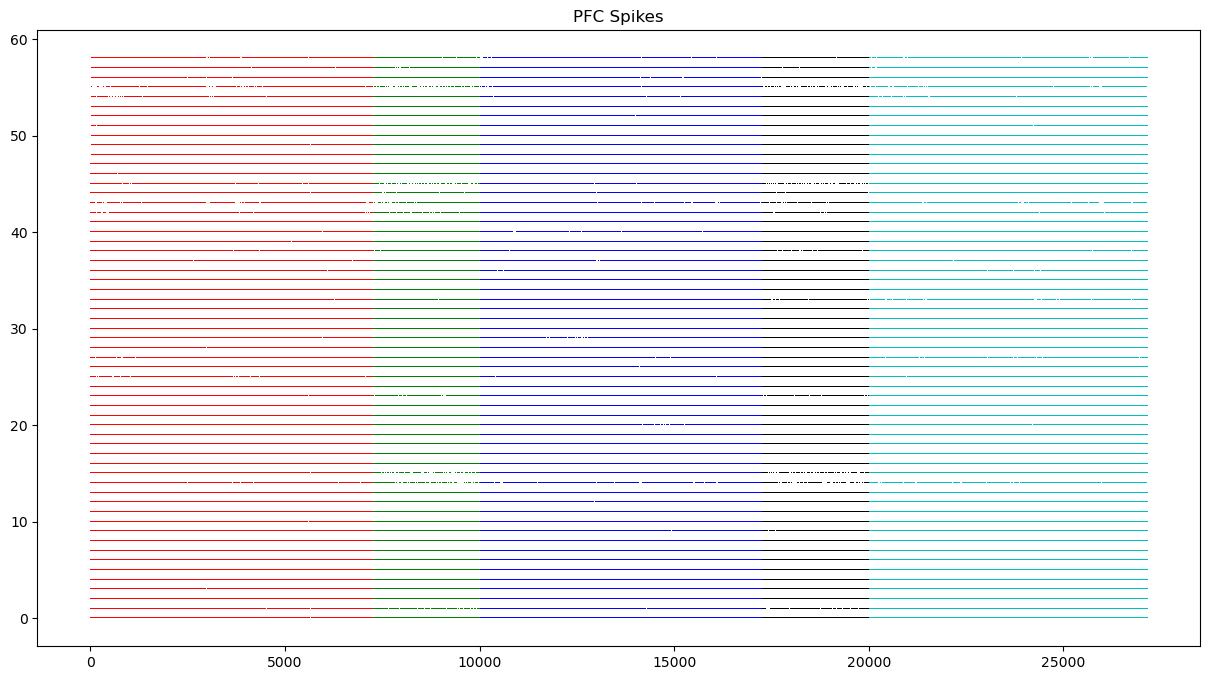

In [5]:
plt.figure(figsize=(15,8))
for (stage, color) in zip(spikes_hpc, ['r', 'g', 'b', 'k', 'c']):
    for i,times in enumerate(stage):
        plt.plot(times, np.ones(len(times)) * i, color + ',')
    plt.title('HPC Spikes')
plt.show()

plt.figure(figsize=(15,8))
for (stage, color) in zip(spikes_nr, ['r', 'g', 'b', 'k', 'c']):
    for i,times in enumerate(stage):
        plt.plot(times, np.ones(len(times)) * i, color + ',')
    plt.title('NR Spikes')
plt.show()

plt.figure(figsize=(15,8))
for (stage, color) in zip(spikes_pfc, ['r', 'g', 'b', 'k', 'c']):
    for i,times in enumerate(stage):
        plt.plot(times, np.ones(len(times)) * i, color + ',')
    plt.title('PFC Spikes')
plt.show()

In [ ]:
def firingRate(data, protocol_times=None, bin_size=None, window_size=None, step_size=None, protocol_based=True, per_neuron=False):
    """Compute firing rates efficiently with optional sliding window.

    Args:
      data: Nx2 array of (time, neuron_id), or 1D array of times, or list of per-neuron time arrays.
      protocol_times: list of (start,end) tuples; required when protocol_based=True.
      bin_size: fixed bin width (seconds). If provided and window_size is None, returns binned rates (Hz).
      window_size, step_size: if provided compute sliding-window instantaneous rate with step_size resolution.
      protocol_based: if True, compute per-protocol; otherwise compute over whole recording.
      per_neuron: if True, return per-neuron rates (array shape (N, T)); otherwise return population rate (T,).

    Returns:
      If protocol_based: list of tuples (t_centers, rates) for each protocol.
      Else: (t_centers, rates) for the whole recording.
    """
    import math

    if protocol_based and (protocol_times is None):
        raise ValueError('protocol_times must be provided when protocol_based=True')

    # detect input type
    is_raw = isinstance(data, np.ndarray) and data.ndim == 2
    is_times = isinstance(data, np.ndarray) and data.ndim == 1
    is_list = isinstance(data, (list, tuple))

    sliding = (window_size is not None) and (step_size is not None)

    def _edges_centers(start, end, step):
        edges = np.arange(start, end + step, step)
        centers = (edges[:-1] + edges[1:]) / 2.0
        return edges, centers

    def _bin_counts_raw(times, idxs, start, end, edges, min_idx, N):
        T = len(edges) - 1
        if times.size == 0:
            return np.zeros((N, T), dtype=int)
        mask = (times >= start) & (times < end)
        tsub = times[mask]
        isub = idxs[mask] - min_idx
        if tsub.size == 0:
            return np.zeros((N, T), dtype=int)
        bin_idx = np.searchsorted(edges, tsub, side='right') - 1
        valid = (bin_idx >= 0) & (bin_idx < T) & (isub >= 0) & (isub < N)
        if not np.any(valid):
            return np.zeros((N, T), dtype=int)
        lin = isub[valid] * T + bin_idx[valid]
        arr = np.bincount(lin, minlength=N * T).reshape(N, T)
        return arr

    def _counts_from_single_raster(single_raster, edges):
        T = len(edges) - 1
        N = len(single_raster)
        counts = np.zeros((N, T), dtype=int)
        for i, times_i in enumerate(single_raster):
            if len(times_i) == 0:
                continue
            counts[i], _ = np.histogram(times_i, bins=edges)
        return counts

    def _sliding_from_counts(counts, window_size, step_size):
        if counts.ndim == 1:
            counts = counts[np.newaxis, :]
            squeeze = True
        else:
            squeeze = False
        bin_dt = step_size
        W = max(1, int(round(window_size / bin_dt)))
        kernel = np.ones(W, dtype=float)
        out = np.empty_like(counts, dtype=float)
        for i in range(counts.shape[0]):
            conv = np.convolve(counts[i], kernel, mode='same')
            out[i] = conv / (W * bin_dt)
        if squeeze:
            return out[0]
        return out

    def _process_interval(start, end):
        if sliding:
            edges, centers = _edges_centers(start, end, step_size)
            if is_raw:
                times = data[:, 0]
                idxs = data[:, 1].astype(int)
                min_idx = int(np.min(idxs))
                max_idx = int(np.max(idxs))
                N = max_idx - min_idx + 1
                counts = _bin_counts_raw(times, idxs, start, end, edges, min_idx, N)
                rates = _sliding_from_counts(counts, window_size, step_size)
                if per_neuron:
                    return centers, rates
                else:
                    return centers, rates.sum(axis=0)
            elif is_list:
                edges, centers = _edges_centers(start, end, step_size)
                counts = _counts_from_single_raster(data, edges)
                rates = _sliding_from_counts(counts, window_size, step_size)
                if per_neuron:
                    return centers, rates
                else:
                    return centers, rates.sum(axis=0)
            else:
                edges, centers = _edges_centers(start, end, step_size)
                mask = (data >= start) & (data < end)
                sub = data[mask]
                counts, _ = np.histogram(sub, bins=edges)
                rates = _sliding_from_counts(counts, window_size, step_size)
                return centers, rates
        else:
            if bin_size is None:
                raise ValueError('bin_size must be provided when window_size is None')
            edges = np.arange(start, end + bin_size, bin_size)
            centers = (edges[:-1] + edges[1:]) / 2.0
            if is_raw:
                times = data[:, 0]
                idxs = data[:, 1].astype(int)
                min_idx = int(np.min(idxs))
                max_idx = int(np.max(idxs))
                N = max_idx - min_idx + 1
                counts = _bin_counts_raw(times, idxs, start, end, edges, min_idx, N)
                if per_neuron:
                    return centers, counts / bin_size
                else:
                    return centers, counts.sum(axis=0) / bin_size
            elif is_list:
                counts = _counts_from_single_raster(data, edges)
                if per_neuron:
                    return centers, counts / bin_size
                else:
                    return centers, counts.sum(axis=0) / bin_size
            else:
                mask = (data >= start) & (data < end)
                sub = data[mask]
                counts, _ = np.histogram(sub, bins=edges)
                return centers, counts / bin_size

    if protocol_based:
        results = []
        for (start, end) in protocol_times:
            centers, rates = _process_interval(start, end)
            results.append((centers, rates))
        return results
    else:
        if is_raw:
            times = data[:, 0]
            start = float(np.min(times))
            end = float(np.max(times))
        elif is_times:
            start = float(np.min(data))
            end = float(np.max(data))
        elif is_list:
            mins = [np.min(t) for t in data if len(t) > 0]
            maxs = [np.max(t) for t in data if len(t) > 0]
            start = float(min(mins)) if mins else 0.0
            end = float(max(maxs)) if maxs else 0.0
        centers, rates = _process_interval(start, end)
        return centers, rates

In [ ]:
# Save both old and current `firingRate` implementations to files.
import inspect

# Old (original) implementation captured as a string for backup
def firingRate_old(data, protocol_times, bin_size=1.0, protocol_based=True):
    """
    Original (pre-fix) firingRate kept for reference.
    """
    protocol_rates = []
    if data.size == 0:
        return protocol_rates

    times = data[:,0]
    M = np.size(times)
    print(M)
    bins = np.arange(np.min(times), np.max(times) + bin_size, bin_size)

    if not protocol_based:
        # If not protocol based, return population firing rates for entire recording
        counts, _ = np.histogram(times, bins=bins)
        population_rate = counts / M
        return population_rate

    population_rates = []
    for start, end in protocol_times:
        # Select spikes in interval 
        counts, _ = np.histogram(times, bins=bins, range=(start, end))
        mask = (times >= start) & (times <= end)
        sub_times = times[mask]
        rel_M = np.size(sub_times)
        rate = counts / rel_M

        population_rates.append(rate)
    
    return population_rates

